In [2]:
import igraph as ig
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

In [3]:
g_crates = ig.Graph.Read_GraphML("../../networks/crates_io_lcc.graphml")
g_pypi = ig.Graph.Read_GraphML("../../networks/pypi_lcc.graphml")
g_npm = ig.Graph.Read_GraphML("../../networks/npm_prod_lcc.graphml")

/tmp/ipykernel_41949/3860929966.py:1: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g_crates = ig.Graph.Read_GraphML("../../networks/crates_io_lcc.graphml")
/tmp/ipykernel_41949/3860929966.py:2: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g_pypi = ig.Graph.Read_GraphML("../../networks/pypi_lcc.graphml")
/tmp/ipykernel_41949/3860929966.py:3: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g_npm = ig.Graph.Read_GraphML("../../networks/npm_prod_lcc.graphml")


In [4]:
package = "vue"

print("All nodes:", len(g_npm.vs))
print(
    f"{package} in-component:",
    len(g_npm.subcomponent(g_npm.vs.find(name=package), mode="in")),
)
print(f"{package} in-degree:", g_npm.vs.find(name=package).degree(mode="in"))
print(
    "Percent: ",
    100 * g_npm.vs.find(name=package).degree(mode="in") / len(g_npm.vs),
)

All nodes: 1518107
vue in-component: 65938
vue in-degree: 62625
Percent:  4.12520329594686


In [19]:
components = g_npm.components()

top_largest = sorted(
    [(len(c), c) for c in components], key=lambda x: x[0], reverse=True
)[:10]

print("Top 10 largest components:")
for size, component in top_largest:
    print(size, "nodes")

Top 10 largest components:
91 nodes
85 nodes
69 nodes
43 nodes
36 nodes
24 nodes
22 nodes
21 nodes
19 nodes
19 nodes


In [103]:
crates_vulns = pd.read_csv("../vulnerability/cargo_grouped.csv")
npm_vulns = pd.read_csv("../vulnerability/npm_grouped.csv")
pypi_vulns = pd.read_csv("../vulnerability/pypi_grouped.csv")

In [4]:
def leiden_communities(graph):
    communities = graph.as_undirected().community_leiden(
        objective_function="modularity", n_iterations=-1
    )

    lengths = [len(comm) for comm in communities]
    args = np.argsort(lengths)[::-1]

    for i in args[:10]:
        print(i, lengths[i])

    return communities


communities = leiden_communities(g_crates)

25 24629
0 23330
11 16302
28 10513
1 9150
2 8891
16 4958
15 3724
17 2593
12 2347


In [121]:
test = []
for index, (date, package, ecosystem, score) in tqdm(
    crates_vulns.iterrows(), desc="Enumerating vulnerabilities"
):
    try:
        package_id = g_crates.vs.find(name=package).index
        comm = communities.membership[package_id]
        test.append(comm)
    except ValueError:
        # Package is not in the graph
        pass

Counter(test)

471it [00:00, 5086.62it/s]


Counter({1: 100,
         3: 77,
         7: 70,
         0: 69,
         2: 34,
         8: 21,
         16: 14,
         11: 12,
         12: 10,
         19: 10,
         14: 9,
         5: 7,
         18: 5,
         4: 4,
         13: 3,
         21: 1,
         9: 1,
         17: 1,
         24: 1,
         63: 1,
         41: 1,
         40: 1})

In [20]:
package_to_in_component = {}

for index, (date, package, ecosystem, score) in tqdm(crates_vulns.iterrows()):
    if package not in package_to_in_component:
        try:
            node_index = g_crates.vs.find(name=package).index
            package_to_in_component[package] = g_crates.subcomponent(
                node_index, mode="in"
            )
        except ValueError:
            pass

975it [00:01, 682.18it/s]


In [67]:
comm_index = 54

print(len(comms[comm_index]))

community = g_npm.subgraph(comms[comm_index])
downloads = []
for i in community.vs:
    try:
        downloads.append(int(i["downloads"]))
    except:
        downloads.append(0)

pr = community.pagerank()
top_100 = sorted(
    range(len(pr)),
    key=lambda i: downloads[i],
    reverse=True,
)[:100]

for i in top_100:
    print(community.vs[i]["name"], community.vs[i]["downloads"])

238
@zodash/save-as 92630
@zodash/doreamon 85066
@zodash/logger 78858
@zodash/compose 68521
@zodash/format 67810
@zodash/get 65787
@zodash/onion 65564
@zodash/random 64617
@zcorky/delay 63704
@zcorky/query-string 63131
@zodash/uuid 62676
@zodash/event 62557
@zodash/pick 62533
@zodash/throttle 62447
@zodash/omit 62017
@zodash/fs 61954
@zodash/camel-case 61937
@zodash/to-path 61925
@zodash/find 61899
@zodash/ms 61750
@zodash/delay 61546
@zodash/dom 60860
@zodash/group-by 60843
@zodash/capitalize 60817
@zodash/match 60739
@zodash/memoize 60646
@zodash/debug 60578
@zodash/once 60131
@zodash/jsonp 60107
@zodash/unique 59918
@zodash/snake-case 59770
@zodash/load-script 59628
@zodash/load-css 59529
@zodash/load-js 59464
@zodash/load-image 59162
@zodash/error 57948
@zcorky/deep-equal 57867
@zodash/cookie 57689
@zodash/cache 57069
@zodash/copy 56277
@zodash/down_load 55371
@znode/fs 35290
@zodash/map 33389
@zodash/zip 31525
@znode/execa 30690
@znode/exit-codes 25828
@cliz/core 22969
@zodash/nob

Text(0.5, 0, 'Downloads')

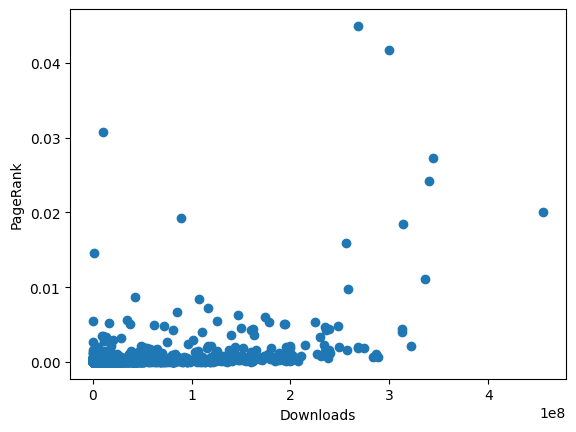

In [10]:
pagerank = g_crates.pagerank()
downloads = g_crates.vs["downloads"]

top_1000 = sorted(range(len(pagerank)), key=lambda i: pagerank[i], reverse=True)[:10000]

top_1000_downloads = [int(downloads[i]) for i in top_1000]

import matplotlib.pyplot as plt

plt.scatter(top_1000_downloads, [pagerank[i] for i in top_1000])
# plt.xscale("log")
# plt.yscale("log")
plt.ylabel("PageRank")
plt.xlabel("Downloads")